<a href="https://colab.research.google.com/github/cristobalperez70-max/Aprendizaje-Maquina/blob/main/Red_Bayesiana_Para_Degradacion_De_Cerveza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propuesta de Red Bayesiana para el Análisis de Degradación en la Cerveza.

**Autor:** Cristóbal Pérez González.

**Fecha:** 2025-11-12

Este cuaderno Colab propone una red bayesiana para analizar la **degradación de la calidad** en la cerveza. Contiene explicación detallada en *markdown*, el código separado en celdas, generación de un dataset sintético (para practicar), aprendizaje de parámetros, visualización y consultas de inferencia.

## Objetivos

1. Proponer una estructura de red bayesiana para modelar la degradación de la calidad en la cerveza.
2. Justificar la elección de **al menos 4 variables causales** que afectan a la variable crítica (calidad).
3. Implementar en Python (Colab) la construcción de la red, generar un dataset sintético, aprender parámetros y realizar consultas de inferencia.

## Breve introducción a las Redes Bayesianas

- Una **red bayesiana (RB)** es un grafo acíclico dirigido donde los nodos representan variables aleatorias y las aristas relaciones causales condicionales.
- Cada nodo tiene una **tabla de probabilidad condicional (CPT / CPD)** que especifica la probabilidad del nodo dado sus padres.
- Las RB son útiles para modelar incertidumbre y razonar por inferencia (p. ej. `P(Calidad | Temperatura=Alta, Tiempo=Largo)`).

En este trabajo proponemos una RB para la **degradación de la cerveza** y justificamos las variables causales.

## Planteamiento del problema

**Variable crítica (objetivo):** `Calidad` (o `Degradación_del_sabor`)

Definimos `Calidad` con tres estados cualitativos: `Buena`, `Aceptable`, `Degradada`.

Queremos modelar las causas principales que afectan esa variable y usar la RB para:
- Aprender parámetros a partir de datos (o de experticia)
- Realizar inferencias (probabilidades condicionales)
- Probar escenarios (what-if)


## Variables causales propuestas y su justificación:

He elegido las siguientes **5 variables**:

1. **Temperatura** (`Temperatura`): Categorías: `Baja`, `Moderada`, `Alta`.
   - Justificación: la temperatura acelera reacciones químicas (oxidación, pérdida de aroma). En trabajos sobre degradación (ej.: vacunas) la temperatura es la variable más influyente.

2. **Tiempo de almacenamiento** (`Tiempo`): Categorías: `Corto`, `Medio`, `Largo`.
   - Justificación: muchas degradaciones son acumulativas — cuanto más tiempo, más probabilidad de pérdida de calidad.

3. **Exposición a la luz** (`Luz`): Categorías: `Baja`, `Alta`.
   - Justificación: la luz, especialmente UV, provoca reacciones de foto-oxidación (skunking en cervezas). Por eso algunas cervezas usan botellas oscuras.

4. **Oxígeno disuelto** (`OD`): Categorías: `Bajo`, `Alto`.
   - Justificación: el oxígeno favorece oxidación de compuestos aromáticos y rancidez.

5. **Tipo de envase / packaging** (`Envase`): Categorías: `Opaco`, `Transparente`.
   - Justificación: afecta la exposición a la luz y la entrada de oxígeno; es un factor indirecto pero importante.

> Se eligio estas variables porque cubren mecanismos físico-químicos y logísticos que se reconocen en la literatura sobre calidad de bebidas: temperatura y tiempo afectan la cinética; luz y oxígeno afectan reacciones específicas; y el envase modera exposición.

## Estructura propuesta (DAG)

Proponemos las siguientes relaciones causales (aristas):

- `Temperatura` → `Calidad`
- `Tiempo` → `Calidad`
- `Luz` → `Calidad`
- `OD` → `Calidad`
- `Envase` → `Luz`  (tipo de envase afecta la exposición a la luz)
- `Temperatura` → `OD` (la temperatura influye en la solubilidad/actividad del oxígeno y reacciones)

Esto modela efectos directos (cada causa → Calidad) y relaciones intermedias (Envase→Luz, Temperatura→OD).

A continuación generaremos un dataset sintético acorde a esta estructura para poder practicar aprendizaje e inferencia.

In [3]:
# Generar dataset sintético en memoria (DataFrame)
import pandas as pd
import numpy as np
np.random.seed(42)
N = 5000

Temperatura = np.random.choice(['Baja','Moderada','Alta'], size=N, p=[0.4,0.4,0.2])
Tiempo = np.random.choice(['Corto','Medio','Largo'], size=N, p=[0.5,0.3,0.2])
Envase = np.random.choice(['Opaco','Transparente'], size=N, p=[0.7,0.3])

# Luz depende del Envase
Luz = []
for e in Envase:
    p = 0.6 if e=='Transparente' else 0.1
    Luz.append(np.random.choice(['Baja','Alta'], p=[1-p,p]))

# OD depende parcialmente de Temperatura
OD = []
for t in Temperatura:
    if t=='Alta':
        OD.append(np.random.choice(['Bajo','Alto'], p=[0.3,0.7]))
    elif t=='Moderada':
        OD.append(np.random.choice(['Bajo','Alto'], p=[0.6,0.4]))
    else:
        OD.append(np.random.choice(['Bajo','Alto'], p=[0.85,0.15]))

# Calidad: heurística probabilística
Calidad = []
for i in range(N):
    score = 0
    if Temperatura[i]=='Alta': score -= 2
    elif Temperatura[i]=='Moderada': score -= 1
    else: score += 1
    if Tiempo[i]=='Largo': score -= 2
    elif Tiempo[i]=='Medio': score -= 1
    else: score += 1
    if Luz[i]=='Alta': score -= 2
    if OD[i]=='Alto': score -= 2
    if Envase[i]=='Opaco': score += 1
    if score >= 2:
        Calidad.append('Buena')
    elif score >= 0:
        Calidad.append('Aceptable')
    else:
        Calidad.append('Degradada')

# Crear DataFrame en memoria
df = pd.DataFrame({
    'Temperatura': Temperatura,
    'Tiempo': Tiempo,
    'Envase': Envase,
    'Luz': Luz,
    'OD': OD,
    'Calidad': Calidad
})

# Mostrar primeras filas
print("DataFrame generado")
df.head()

DataFrame generado


,Temperatura,Tiempo,Envase,Luz,OD,Calidad
0,Baja,Corto,Opaco,Baja,Bajo,Buena
1,Alta,Corto,Opaco,Baja,Bajo,Aceptable
2,Moderada,Largo,Opaco,Baja,Bajo,Degradada
3,Moderada,Corto,Opaco,Baja,Alto,Degradada
4,Baja,Largo,Opaco,Baja,Bajo,Aceptable


In [5]:
# Estadísticas rápidas del DataFrame
print(df.shape)
print('\nDistribuciones marginales:')
for c in df.columns:
    print('\n--', c)
    print(df[c].value_counts())

(5000, 6)

Distribuciones marginales:

-- Temperatura
Temperatura
Baja        2033
Moderada    1968
Alta         999
Name: count, dtype: int64

-- Tiempo
Tiempo
Corto    2576
Medio    1461
Largo     963
Name: count, dtype: int64

-- Envase
Envase
Opaco           3475
Transparente    1525
Name: count, dtype: int64

-- Luz
Luz
Baja    3700
Alta    1300
Name: count, dtype: int64

-- OD
OD
Bajo    3132
Alto    1868
Name: count, dtype: int64

-- Calidad
Calidad
Degradada    2872
Aceptable    1496
Buena         632
Name: count, dtype: int64


## Aprendizaje de la red en Colab (librerías)

En la siguiente celda se indican los comandos para instalar las librerías necesarias en Colab (pgmpy, networkx). Ejecuta la celda si trabajas en Colab.

> **Nota:** en este cuaderno no forzamos la instalación automática aquí — la celda muestra los comandos que debes ejecutar en Colab antes de las celdas que usan `pgmpy`.

In [6]:
# Si estás en Colab, ejecuta esta celda para instalar dependencias (descomenta si es necesario):
# !pip install pgmpy
# !pip install pygraphviz
# !apt-get install -y graphviz

print('Si trabajas en Colab: descomenta la instalación de paquetes si no los tienes instalados (pgmpy, graphviz).')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove

### Definir la estructura (modelo) y aprender parámetros

A continuación hay código para:
1. Definir el `BayesianModel` con las aristas propuestas.
2. Aprender los CPDs desde el dataset sintético con `MaximumLikelihoodEstimator` o `BayesianEstimator`.
3. Mostrar las CPDs y realizar consultas con `VariableElimination`.

In [7]:
# Definir la red bayesiana y aprender CPDs desde el DataFrame (requiere pgmpy)
try:
    from pgmpy.models import DiscreteBayesianNetwork
    from pgmpy.estimators import MaximumLikelihoodEstimator
    from pgmpy.inference import VariableElimination
except Exception as e:
    print('pgmpy no está instalado. En Colab ejecuta: !pip install pgmpy')
    raise

model = DiscreteBayesianNetwork([
    ('Envase','Luz'),
    ('Temperatura','OD'),
    ('Temperatura','Calidad'),
    ('Tiempo','Calidad'),
    ('Luz','Calidad'),
    ('OD','Calidad')
])

# Aprender CPDs directamente desde df
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Mostrar CPDs
for cpd in model.get_cpds():
    print('CPD de:', cpd.variable)
    print(cpd)
    print()

# Ejemplo de inferencia en memoria
infer = VariableElimination(model)
q = infer.query(['Calidad'], evidence={'Temperatura':'Alta','Tiempo':'Largo','Envase':'Transparente'})
print('\nP(Calidad | Temperatura=Alta, Tiempo=Largo, Envase=Transparente)')
print(q)

CPD de: Envase
+----------------------+-------+
| Envase(Opaco)        | 0.695 |
+----------------------+-------+
| Envase(Transparente) | 0.305 |
+----------------------+-------+

CPD de: Luz
+-----------+---------------------+----------------------+
| Envase    | Envase(Opaco)       | Envase(Transparente) |
+-----------+---------------------+----------------------+
| Luz(Alta) | 0.09870503597122302 | 0.6275409836065574   |
+-----------+---------------------+----------------------+
| Luz(Baja) | 0.901294964028777   | 0.37245901639344264  |
+-----------+---------------------+----------------------+

CPD de: Temperatura
+-----------------------+--------+
| Temperatura(Alta)     | 0.1998 |
+-----------------------+--------+
| Temperatura(Baja)     | 0.4066 |
+-----------------------+--------+
| Temperatura(Moderada) | 0.3936 |
+-----------------------+--------+

CPD de: OD
+-------------+--------------------+-----+-----------------------+
| Temperatura | Temperatura(Alta)  | ... | Temper

## Visualización de la estructura

La siguiente celda dibuja el grafo propuesto:

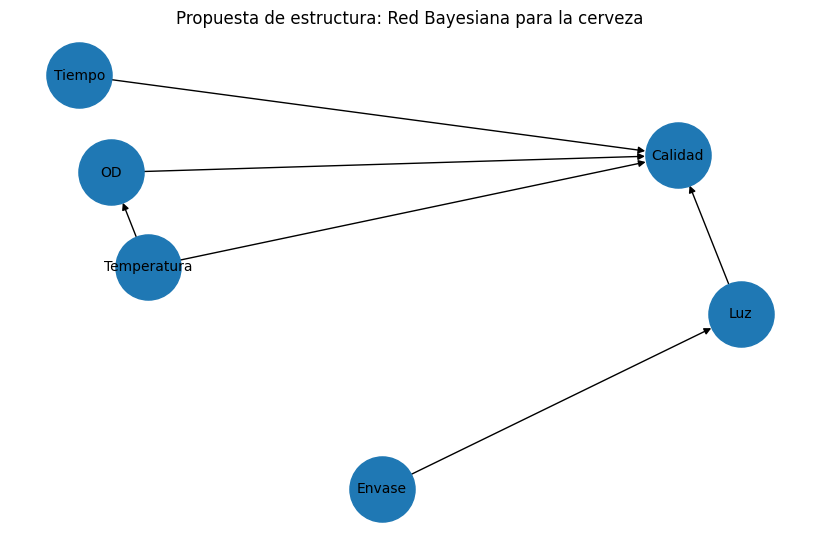

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()
G.add_edges_from([('Envase','Luz'),('Temperatura','OD'),('Temperatura','Calidad'),('Tiempo','Calidad'),('Luz','Calidad'),('OD','Calidad')])
plt.figure(figsize=(8,5))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2200, font_size=10)
plt.title('Propuesta de estructura: Red Bayesiana para la cerveza')
plt.axis('off')
plt.show()

## Escenarios (what‑if)

Ejemplos de preguntas que puedes hacer con la red aprendida:
- ¿Cuál es la probabilidad de `Calidad = Degradada` si `Temperatura=Alta` y `Tiempo=Largo`?
- ¿Qué efecto tiene cambiar el `Envase` a `Opaco` sobre la probabilidad de `Calidad=Buena`?

En el notebook se incluyó una consulta de ejemplo tras aprender los CPDs.

## Conclusión: Limitaciones y recomendaciones

- El dataset usado aquí es sintético y creado con reglas heurísticas; los CPDs aprendidos reflejan esas reglas, no observaciones reales.
- Para un estudio real: recolectar datos de lotes con mediciones (temperatura de almacenamiento, tiempo real, O2 disuelto, tipo de envase, medición sensorial), y ajustar la estructura con técnicas de aprendizaje de estructura si se desea.
- Documentar supuestos y, si es posible, incorporar conocimiento de expertos para las priorizaciones.
